In [2]:
import os
import random
import gensim
# import scopus
import pybliometrics.scopus as scopus
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.decomposition
import sklearn.feature_extraction
import ipywidgets as widgets

from wordcloud import WordCloud
from IPython.display import display
from collections import defaultdict

import seaborn as sns
sns.set('paper')

import logging
logging.getLogger().setLevel(logging.INFO)

# some python 3 trickery
import sys
if sys.version_info[0] >= 3:
    unicode = str

import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud,STOPWORDS
import PyPDF2
import textract

import warnings
warnings.filterwarnings("ignore")

C:\Users\mohabu\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\mohabu\Anaconda3\lib\site-packages\PyPDF2\__init__.py:21: DeprecationWarning: PyPDF2 is deprecated. Please move to the pypdf library instead.
  warnings.warn(


In [3]:
# Get current working directory
current_dir = os.getcwd()

print("Current directory:", current_dir)

Output_folder='All_Mend_Collection_pybliometrics_HP'

Current directory: C:\Users\mohabu\iHelm\Lit_Rev\Analysis_Mend


In [4]:
## Create the output folder
folder_path = r''+Output_folder
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Parameters

In [5]:
seed = 70 # seed for NMF topic model
num_topics = 12

# # query = 'title-abs-key("short sea shipping")'
# query = 'title-abs-key( "Short Sea shipping ") AND PUBYEAR IS 2022'


labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
vis_seed = 6 # seed for t-SNE visualization
vis_angle = 135 # rotation angle for visualization

In [6]:
def prepare_fig(w=1, h=None):
    if h is None: h = w
    figsize = (6 * w, 3 * h)
    sns.set(rc={'figure.figsize': figsize})
    fig = plt.figure(figsize=figsize)
    plt.clf()
    return fig

def top_k(mapping, k=10):
    return sorted(mapping.keys(), key=lambda x: mapping[x])[::-1][:k]

pd.set_option('display.max_rows', 250)

# Import

### Upload data that have file path to upload the corresponding PDF files

The Mendeley pdf files exported to csv file by using Jabref.

Open the .bib-files in Jabref and export them as OpenOffice.csv-files. You find the option under the menu File, Export

There is a difference between the csv exported from Online websites and from Jabref, which is Online website doesn't give the paths of pdf files, and it stuck with too big meta-data!


In [7]:
# meta_df = pd.read_csv('./Mend_Stats/Shipping_Collection/SSS_Mend_HP.csv', error_bad_lines=False)
meta_df = pd.read_csv('./Mend_Stats/Mend_Collection/All_Mend_HP.csv', error_bad_lines=False)


print(meta_df.shape)
meta_df.head()
# meta_df.info

(9372, 31)


b'Skipping line 18: expected 31 fields, saw 35\nSkipping line 19: expected 31 fields, saw 33\nSkipping line 68: expected 31 fields, saw 33\nSkipping line 141: expected 31 fields, saw 33\nSkipping line 181: expected 31 fields, saw 36\nSkipping line 239: expected 31 fields, saw 97\nSkipping line 257: expected 31 fields, saw 33\nSkipping line 308: expected 31 fields, saw 35\nSkipping line 366: expected 31 fields, saw 33\nSkipping line 413: expected 31 fields, saw 34\nSkipping line 415: expected 31 fields, saw 34\nSkipping line 456: expected 31 fields, saw 33\nSkipping line 469: expected 31 fields, saw 38\nSkipping line 512: expected 31 fields, saw 37\nSkipping line 559: expected 31 fields, saw 34\nSkipping line 620: expected 31 fields, saw 32\nSkipping line 687: expected 31 fields, saw 32\nSkipping line 731: expected 31 fields, saw 33\nSkipping line 759: expected 31 fields, saw 46\nSkipping line 835: expected 31 fields, saw 32\nSkipping line 841: expected 31 fields, saw 43\nSkipping line 

,BibliographyType,ISBN,Identifier,Author,Title,Journal,Volume,Number,Month,Pages,...,Howpublished,Institution,Organizations,School,Annote,Custom1,Custom2,Custom3,Custom4,Custom5
0,7,NaN,Farhangi2010,"Farhangi, Hassan",The path of the smart grid,IEEE Power and Energy Magazine,8,1,NaN,18--28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\M...,NaN
1,7,NaN,Sundararajan2021,"Sundararajan, Aditya; Ollis, Ben",Regression and Generalized Additive Model to E...,IEEE Access,PP,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C:\+HP Folders\+Folder2021\+forecasts_2021\Reg...,NaN
2,7,NaN,Lin2018,"Lin, You; Yang, Ming; Wan, Can; Wang, Jianhui;...",A Multi-model Combination Approach for Probabi...,IEEE Transactions on Sustainable Energy,3029,c,NaN,1--1,...,NaN,NaN,NaN,NaN,NaN,Short-term probabilistic wind power forecastin...,NaN,post-processing,C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\M...,NaN
3,7,978-4-431-54438-8,Poh2015,"Poh, Amy; Ling, Ai",The Malaysia-Japan Model on Technology Partner...,NaN,NaN,NaN,NaN,337--343,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C:\All fcsts_2014-18\+forecasts\Ling2015_Chapt...,NaN
4,7,NaN,Vaz2016,"Vaz, A. G. R.; Elsinga, B.; van Sark, W. G. J....",An artificial neural network to assess the imp...,Renewable Energy,85,NaN,NaN,631--641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\M...,NaN


In [8]:
meta_df.shape

meta_df = meta_df[meta_df['Custom4'].notna()]  ### remove rows without pdf file
meta_df.shape

(9170, 31)

# Read the PDF files

## METHOD 1: Using textract

NOTE: textract supports reading of other documents as well like DOCX, JPG etc
Refer: https://textract.readthedocs.io/en/stable/

In [9]:
def read_file_textract(filepath):
    text = textract.process(filepath)
    return text.decode("utf-8") 

## METHOD 2: Using PyPDF

In [10]:
def read_file_pypdf(filepath):
    pdfFileObj = open(filepath,'rb')
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
    num_pages = pdfReader.numPages
    text = ""
    # Read all the pages
    for pg in range(num_pages):
        page = pdfReader.getPage(pg)
        text += page.extractText()
    return text      

## Read file using any of the pdf readers

In [11]:
def read_file(filepath, use_method = 'textract'):
    
    text = ""
    if not os.path.isfile(filepath):
        print(f'Invalid file:{filepath}')
    else:
        if use_method == 'textract':
            return read_file_textract(filepath)
        elif use_method == 'pypdf':
            return read_file_pypdf(filepath)
        else:
            print('Invalid method to read file. Supported formats: "textract" or "pypdf".')
    
    return text

# Identify the keywords in the document

In [12]:
def extract_keywords(text, ignore_words = [],
                     min_word_length = 0,
                     ignore_numbers = True,
                     ignore_case = True):
    # Remove words with special characters
    filtered_text = ''.join(filter(lambda x:x in string.printable, text))
    
    # Create word tokens from the text string
    tokens = word_tokenize(filtered_text)
    
    # List of punctuations to be ignored 
    punctuations = ['(',')',';',':','[',']',',','.','--','-','#','!','*','"','%']
    
    # Get the stopwords list to be ignored
    stop_words = stopwords.words('english')

    # Convert ignore words from user to lower case
    ignore_words_lower = [x.lower() for x in ignore_words]
    
    # Combine all the words to be ignored
    all_ignored_words = punctuations + stop_words + ignore_words_lower
    
    # Get the keywords list
    keywords = [word for word in tokens \
                    if  word.lower() not in all_ignored_words
                    and len(word) >= min_word_length]    

    # Remove keywords with only digits
    if ignore_numbers:
        keywords = [keyword for keyword in keywords if not keyword.isdigit()]

    # Return all keywords in lower case if case is not of significance
    if ignore_case:
        keywords = [keyword.lower() for keyword in keywords]
    
    return keywords

In [13]:
import warnings
warnings.filterwarnings("ignore")
meta_df['body_text']='NaN'
meta_df['keywords']='NaN'

dict_ = {'body_text': [], 'keywords': []}

all_keywords= []


nfiles=str(len(meta_df))
ignore_words = ['Fig','like','e.g.','i.e.','one']
all_keywords = []
d=0
bar = widgets.IntProgress(
    min=0, 
    max=len(meta_df), 
    description='Loading')
display(bar)


for i in range(len(meta_df)):
    try:
        filename=meta_df['Custom4'][i]
        if filename.endswith('.pdf'):
            bar.value += 1
            bar.description = str(bar.value)
            try:
                dict_['body_text'].append(read_file(filename))
                dict_['keywords'].append(extract_keywords(dict_['body_text'][i],min_word_length = 3, ignore_words = ignore_words) )
                meta_df['keywords'][i]=dict_['keywords'][i]
                all_keywords.extend(dict_['keywords'][i])

            except:
                print(f'ERROR!!! Unable to parse file: {filename}. Ignoring file!!')
                d=d+1
    except:
        print('unable to read the path')
        dict_['body_text'].append('')
        dict_['keywords'].append('')


IntProgress(value=0, description='Loading', max=9170)

Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Farhangi - 2010 - The path of the smart grid.pdf
Invalid file:C:\+HP Folders\+Folder2021\+forecasts_2021\Regression_and_Generalized_Additive_Model_to_Enhance_the_Performance_of_Photovoltaic_Power_Ensemble_Predictors.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Lin et al. - 2018 - A Multi-model Combination Approach for Probabilistic Wind Power Forecasting.pdf
Invalid file:C:\All fcsts_2014-18\+forecasts\Ling2015_Chapter_JapanAndUSSmartGridEffortACase.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Vaz et al. - 2016 - An artificial neural network to assess the impact of neighbouring photovoltaic systems in power forecasting in Utrec.pdf
unable to read the path
Invalid file:C:\+HP Folders\+Folder2021\+forecasts_2021\50vt03El-Jabu.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\

Invalid file:C:/Users/Mhdella/AppData/Local/Mendeley Ltd./Mendeley Desktop/Downloaded/Mart{'{i}}nez-anido, Florita, Hodge - 2014 - The Impact of Improved Solar Forecasts on Bulk Power System Operations in ISO-NE Preprint.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Albadi et al. - 2021 - Enhancing electricity supply mix in Oman with energy storage systems a case study.pdf
Invalid file:C:\+HP Folders\+Folder2021\+forecasts_2021\bingham2008.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Black - 2018 - Weather Data for Energy Analytics.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Ren, Suganthan, Srikanth - 2015 - Ensemble methods for wind and solar power forecasting—A state-of-the-art review(2).pdf
Invalid file:C:\+HP Folders\+Folder 2022\+forecasts_2022\On_the_History_and_Future_of_100_Renewable_Energy_Systems_Research.pdf
Invalid file:C:\Users\Mhdella\AppD

Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Cormode et al. - 2013 - Comparing ramp rates from large and small PV systems, and selection of batteries for ramp rate control.pdf
Invalid file:C:/+HP Folders/+Folder2019/+forecasts_2019/ARENAreport-PublicationofPVpowermeasurements1.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Dudoit, Fridlyans, Speed - 2002 - Comparison of discrimination methods for the classification of tumors using gene expression data.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Elrajoubi, Ang, Abushaiba - 2017 - TMS320F28335 DSP programming using MATLAB Simulink embedded coder Techniques and advancements.pdf
Invalid file:C:/+HP Folders/+Folder2019/+forecasts_2019/Primer on DL in Genomics.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Stokes - 2021 - B RUNEL U NIVERSITY L ONDON Artificial Intelligenc

Invalid file:C:/+HP Folders/+Folder2020/+forecasts_2020/1-s2.0-S0038092X19312563-main.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Shivashankar et al. - 2016 - Mitigating methods of power fluctuation of photovoltaic (PV) sources - A review.pdf
Invalid file:C:\+HP Folders\+Folder 2022\+shipping\Optimal Ship Routing_Thesis-MIT2008.pdf
Invalid file:C:\All fcsts_2014-18\+forecasts\+forecast\Forecast solutions for renewables.pdf
Invalid file:C:\All fcsts_2014-18\+forecasts\+UVIG 2014 forecasting workshop\Hoff.pdf
Invalid file:C:\+HP Folders\+Folder2021\+forecasts_2021\Technical paper (by Mun Bock).pdf
Invalid file:C:\+HP Folders\+Folder 2022\+shipping\Borkowski, P. (2017). The ship movement trajectory prediction algorithm using navigational data fusion. Sensors, 17(6), 1432..pdf
Invalid file:C:\+HP Folders\+Folder2021\+forecasts_2021\24901-61436-2-PB.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Zeng et

Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Zis, Psaraftis, Ding - 2020 - Ship weather routing A taxonomy and survey.pdf
Invalid file:C:\+HP Folders\+Folder2021\+forecasts_2021\welsch2013.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Aghahosseini et al. - 2018 - Analysis of 100% renewable energy for Iran in 2030 integrating solar PV, wind energy and storage.pdf
Invalid file:C:\All fcsts_2014-18\+forecasts\+forecast\Transmission system performance analysis for high-penetration photovoltaics.pdf
Invalid file:C:/+HP Folders/+Folder2019/+forecasts_2019/khangamification_sigcse2014FINAL.pdf
Invalid file:C:/+HP Folders/+Folder2019/+forecasts_2019/Advance Metering Infrastructure.pdf
Invalid file:C:\+HP Folders\+Folder 2022\+shipping\document+(2).pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Petersen, Winther, Jacobsen - 2012 - A machine-learning approach to predict 

Invalid file:C:\+HP Folders\+Folder 2022\+shipping\1-s2.0-S0029801822008095-main.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Yang - 2018 - SolarData An R package for easy access of publicly available solar datasets.pdf
Invalid file:C:\+HP Folders\+Folder2021\+ebooks_2021\Bayesuvius,a small visual dictionary of Bayesian Networks.pdf
Invalid file:C:\+HP Folders\+Folder 2022\+shipping\Ship Resistance And Propulsion.pdf
Invalid file:C:/+HP Folders/+Folder2019/+forecasts_2019/100350_en.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Hand - 2011 - Electric Motor Maintenance and Troubleshooting.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Patton - 1972 - A probability method for bulk power system security assessment-III-models for stand-by generators and field data collect.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\

Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Luoma, Mathiesen, Kleissl - 2014 - Forecast value considering energy pricing in California.pdf
Invalid file:C:\All fcsts_2014-18\+forecasts\6A_3_TENE18_097_paper_AndriyVovk.pdf
Invalid file:C:\+HP Folders\+Folder 2022\+shipping\Neural_Network_Approach_for_Pr.pdf
Invalid file:C:\All fcsts_2014-18\+forecasts\NAPS2015_Amini.pdf
Invalid file:C:\+HP Folders\+Folder 2022\+forecasts_2022\efic_slides_share\T4_Browell.pdf
Invalid file:C:\+HP Folders\+Folder 2022\+shipping\1-s2.0-S0029801819302616-main.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Corres - 2017 - Five Good Reasons Why the Short Sea Initiative has Failed in Europe .pdf
Invalid file:C:\+HP Folders\+Folder 2022\+shipping\maaz,+JRGEV9A12-Oleg.pdf
Invalid file:C:\+HP Folders\+Folder2021\+ebooks_2021\Cases_Glover Book Articles\2010_IEEE_POT_GIS.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\M

Invalid file:C:\+HP Folders\+Folder2021\+shipping\energies-13-04769.pdf
Invalid file:C:\+HP Folders\+Folder 2022\+shipping\Gaps and requirements for automatic generation of space layouts with optimised energy performance.pdf
Invalid file:C:\+HP Folders\+Folder 2022\+shipping\Yanchin-Petrov2021_Article_ValidationAndRefinementOfAShip.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\WIRE - 2012 - WIRE Weather Intelligence for Renewable Energies - Current State Report 2012.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Perera, Mo - 2016 - Data analysis on marine engine operating regions in relation to ship navigation.pdf
Invalid file:C:\+HP Folders\+Folder 2022\+forecasts_2022\2306.11682.pdf
Invalid file:C:\+HP Folders\+Folder2021\+forecasts_2021\RAND_CFA521-1.pdf
Invalid file:C:\+HP Folders\+Folder2021\+forecasts_2021\kumar2020.pdf
Invalid file:C:/+HP Folders/+Folder2020/+forecasts_2020/energies-12-01374-v

Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\World Economic Forum - 2018 - Fostering Effective Energy Transition A Fact-Based Framework to Support Decision-Making With analytical su.pdf
Invalid file:C:/+HP Folders/+Folder 2022/+shipping/Statistical analysis of waves' effects on ship navigation using.pdf
Invalid file:C:\+HP Folders\+Folder2021\+ebooks_2021\SI-Brochure-9-EN.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Unknown - Unknown - PMU and WAMS.pdf.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Antonanzas-Torres et al. - 2014 - Towards downscaling of aerosol gridded dataset for improving solar resource assessment, an application.pdf
unable to read the path
Invalid file:C:\+HP Folders\+Folder2021\+forecasts_2021\Success Factors Impacting Artificial Intelligence Adoption --- Pe.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\D

Invalid file:C:\+HP Folders\+Folder2021\+Reads 2021\Amid Armed Conflict-Impact of Covid-19 in Western Libya.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Abu-Mostafa - 2012 - Machines that Think for Themselves.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Botterud et al. - 2009 - Wind Power Forecasting and Electricity Market Operations by.pdf
Invalid file:C:\All fcsts_2014-18\+forecasts\07747861.pdf
Invalid file:C:\+HP Folders\+Folder2021\+ebooks_2021\Appraisal and Evaluation of Energy Efficiency in Saudi.pdf
Invalid file:C:\All fcsts_2014-18\+forecasts\Forecasting_Regional_Photovoltaic_Power_Generation.pdf
Invalid file:C:\All fcsts_2014-18\+forecasts\Xie_PSERC_Webinar_Oct_2015_Announcement.pdf
Invalid file:C:/+HP Folders/+Folder2020/+forecasts_2020/2035-Report.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Fellow et al. - Unknown - ,v 52&2) 0hdvxuhdeoh.pdf

Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Almeida, Perpin, Narvarte - 2015 - PV power forecast using a nonparametric PV model.pdf
Invalid file:C:\+HP Folders\+Folder2021\+forecasts_2021\1905.09498.pdf
Invalid file:C:\+HP Folders\+Folder2021\+forecasts_2021\s41586-021-03854-z.pdf
Invalid file:C:\+HP Folders\+Folder 2022\+forecasts_2022\Who are the 100 largest scientific.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Chondrodima et al. - 2022 - Machine Learning Models for Vessel Route Forecasting An Experimental Comparison.pdf
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Elvia - 2021 - Electric vehicles and power consumption at home – an analysis of charging patterns in Norway in 2020.pdf
Invalid file:C:/Users/Mhdella/AppData/Local/Mendeley Ltd./Mendeley Desktop/Downloaded/{v{Z}}i{v{z}}ka - 2006 - Support vector machines (SVM).pdf
Invalid file:C:\Users\Mhdella\A

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ERROR!!! Unable to parse file: C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Yahia, Eltieb - 2008 - ‫الرحيم‬ ‫الرحمن‬ ‫هللا‬ ‫بسم‬ A Dissertation.pdf. Ignoring file!!
Invalid file:C:\All fcsts_2014-18\+forecasts\wp2017n6.pdf
ERROR!!! Unable to parse file: C:\All fcsts_2014-18\+forecasts\wp2017n6.pdf. Ignoring file!!
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Pryor - 2020 - Climate Science and its relevance to Renewable Energy.pdf
ERROR!!! Unable to parse file: C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Pryor - 2020 - Climate Science and its relevance to Renewable Energy.pdf. Ignoring file!!
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Lahouar, Ben Hadj Slama - 2015 - Day-ahead load forecast using random forest and expert input selection.pdf
ERROR!!! Unable to parse file: C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Laho

Invalid file:C:/+HP Folders/+Folder2019/+forecasts_2019/Forecast Intern at CAISO.pdf
ERROR!!! Unable to parse file: C:/+HP Folders/+Folder2019/+forecasts_2019/Forecast Intern at CAISO.pdf. Ignoring file!!
Invalid file:C:\+HP Folders\+Folder 2022\+shipping\TITS.2017.2789279.pdf
ERROR!!! Unable to parse file: C:\+HP Folders\+Folder 2022\+shipping\TITS.2017.2789279.pdf. Ignoring file!!
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Heckenbergerova, Musilek, Janata - 2016 - Sensitivity analysis of PCA method for wind ramp event detection.pdf
ERROR!!! Unable to parse file: C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Heckenbergerova, Musilek, Janata - 2016 - Sensitivity analysis of PCA method for wind ramp event detection.pdf. Ignoring file!!
Invalid file:C:\+HP Folders\+Folder 2022\+shipping\1-s2.0-S0968090X22002741-main.pdf
ERROR!!! Unable to parse file: C:\+HP Folders\+Folder 2022\+shipping\1-s2.0-S0968090X22002741-main.p

Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Panchal, Stegen, Lu - 2018 - Review of static and dynamic wireless electric vehicle charging system.pdf
ERROR!!! Unable to parse file: C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Panchal, Stegen, Lu - 2018 - Review of static and dynamic wireless electric vehicle charging system.pdf. Ignoring file!!
Invalid file:C:\+HP Folders\+Folder 2022\+forecasts_2022\5.0098482.pdf
ERROR!!! Unable to parse file: C:\+HP Folders\+Folder 2022\+forecasts_2022\5.0098482.pdf. Ignoring file!!
Invalid file:C:\+HP Folders\+Folder2021\+forecasts_2021\1-s2.0-S0360544217320844-main.pdf
ERROR!!! Unable to parse file: C:\+HP Folders\+Folder2021\+forecasts_2021\1-s2.0-S0360544217320844-main.pdf. Ignoring file!!
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Bila et al. - 2017 - Vehicles of the Future A Survey of Research on Safety Issues.pdf
ERROR!!! Unable to pa

Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Brown, Bivort - 2018 - Ethology as a physical science.pdf
ERROR!!! Unable to parse file: C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Brown, Bivort - 2018 - Ethology as a physical science.pdf. Ignoring file!!
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\DeSilva - 2018 - Decentralized Solar PV generation forecast based on peer-to-peer approach.pdf
ERROR!!! Unable to parse file: C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\DeSilva - 2018 - Decentralized Solar PV generation forecast based on peer-to-peer approach.pdf. Ignoring file!!
unable to read the path
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Bocquet et al. - 2017 - Assessment of Probabilistic PV Production Forecasts Performance in an Operational Context(2).pdf
ERROR!!! Unable to parse file: C:\Users\Mhdella\A

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Blog - 2017 - Forecasting & Time Series Analysis – Manufacturing Case Study Example Life is a Sine Wave.pdf
ERROR!!! Unable to parse file: C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Blog - 2017 - Forecasting & Time Series Analysis – Manufacturing Case Study Example Life is a Sine Wave.pdf. Ignoring file!!
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Perera, Kamalaruban - 2021 - Applications of reinforcement learning in energy systems.pdf
ERROR!!! Unable to parse file: C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Perera, Kamalaruban - 2021 - Applications of reinforcement learning in energy systems.pdf. Ignoring file!!
Invalid file:C:\+HP Folders\+Folder2021\+forecasts_2021\1-s2.0-S1364032116310863-main.pdf
ERROR!!! Unable to parse file: C:\+HP Folders\+Folder2021\+forecasts_2021\1-s2.0-S1364032116310863-m

Invalid file:C:\+HP Folders\+Folder 2022\+shipping\IET Intelligent Trans Sys - 2018 - Zhang - Combining weather condition data to predict traffic flow  a GRU‐based deep.pdf
ERROR!!! Unable to parse file: C:\+HP Folders\+Folder 2022\+shipping\IET Intelligent Trans Sys - 2018 - Zhang - Combining weather condition data to predict traffic flow  a GRU‐based deep.pdf. Ignoring file!!
Invalid file:C:\All fcsts_2014-18\+forecasts\Forecasting Solar Photovoltaic Power Production at the Aggregated System Level.pdf
ERROR!!! Unable to parse file: C:\All fcsts_2014-18\+forecasts\Forecasting Solar Photovoltaic Power Production at the Aggregated System Level.pdf. Ignoring file!!
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Analytics, Modeling - 2021 - An Overview of Topics Extraction in Python with Latent Dirichlet Allocation - KDnuggets.pdf
ERROR!!! Unable to parse file: C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Analytics, Modeli

Invalid file:C:\All fcsts_2014-18\+forecasts\1-s2.0-S187661021734506X-main.pdf
ERROR!!! Unable to parse file: C:\All fcsts_2014-18\+forecasts\1-s2.0-S187661021734506X-main.pdf. Ignoring file!!
Invalid file:C:/Users/Mhdella/AppData/Local/Mendeley Ltd./Mendeley Desktop/Downloaded/City - 2018 - Game-Changer TEPCO ' s Smart Grid Strategy Could Impact Grid Modernization Worldwide.pdf
ERROR!!! Unable to parse file: C:/Users/Mhdella/AppData/Local/Mendeley Ltd./Mendeley Desktop/Downloaded/City - 2018 - Game-Changer TEPCO ' s Smart Grid Strategy Could Impact Grid Modernization Worldwide.pdf. Ignoring file!!
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Lerch, Thorarinsdottir - 2013 - Comparison of non-homogeneous regression models for probabilistic wind speed forecasting Comparison of n.pdf
ERROR!!! Unable to parse file: C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Lerch, Thorarinsdottir - 2013 - Comparison of non-homogeneous r

Invalid file:C:/+HP Folders/+Folder2019/+forecasts_2019/Benestad-2016-Learning-from-mistakes-in-climate-r.pdf
ERROR!!! Unable to parse file: C:/+HP Folders/+Folder2019/+forecasts_2019/Benestad-2016-Learning-from-mistakes-in-climate-r.pdf. Ignoring file!!
Invalid file:C:\+HP Folders\+Folder2021\+ebooks_2021\Cases_Glover Book Articles\varistar-type-aze-station-class-surge-arresters-for-systems-through-345-kv-ieee-certified-catalog-ca235022en.pdf
ERROR!!! Unable to parse file: C:\+HP Folders\+Folder2021\+ebooks_2021\Cases_Glover Book Articles\varistar-type-aze-station-class-surge-arresters-for-systems-through-345-kv-ieee-certified-catalog-ca235022en.pdf. Ignoring file!!
Invalid file:C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Farahnakian et al. - 2023 - A Comprehensive Study of Clustering-Based Techniques for Detecting Abnormal Vessel Behavior.pdf
ERROR!!! Unable to parse file: C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\Mendeley Desktop\Downloaded\Farahnakia

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
print(i+1, len(meta_df))

9170 9170


In [15]:
dict_['keywords']
all_keywords

len(dict_['body_text'])
len(dict_['keywords'])

len(all_keywords)

0

In [16]:
meta_df['body_text'] = pd.DataFrame(dict_['body_text'])
#### meta_df['keywords'] = pd.DataFrame(dict_['keywords'])

meta_df.head()

,BibliographyType,ISBN,Identifier,Author,Title,Journal,Volume,Number,Month,Pages,...,Organizations,School,Annote,Custom1,Custom2,Custom3,Custom4,Custom5,body_text,keywords
0,7,NaN,Farhangi2010,"Farhangi, Hassan",The path of the smart grid,IEEE Power and Energy Magazine,8,1,NaN,18--28,...,NaN,NaN,NaN,NaN,NaN,NaN,C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\M...,NaN,,[]
1,7,NaN,Sundararajan2021,"Sundararajan, Aditya; Ollis, Ben",Regression and Generalized Additive Model to E...,IEEE Access,PP,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,C:\+HP Folders\+Folder2021\+forecasts_2021\Reg...,NaN,,[]
2,7,NaN,Lin2018,"Lin, You; Yang, Ming; Wan, Can; Wang, Jianhui;...",A Multi-model Combination Approach for Probabi...,IEEE Transactions on Sustainable Energy,3029,c,NaN,1--1,...,NaN,NaN,NaN,Short-term probabilistic wind power forecastin...,NaN,post-processing,C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\M...,NaN,,[]
3,7,978-4-431-54438-8,Poh2015,"Poh, Amy; Ling, Ai",The Malaysia-Japan Model on Technology Partner...,NaN,NaN,NaN,NaN,337--343,...,NaN,NaN,NaN,NaN,NaN,NaN,C:\All fcsts_2014-18\+forecasts\Ling2015_Chapt...,NaN,,[]
4,7,NaN,Vaz2016,"Vaz, A. G. R.; Elsinga, B.; van Sark, W. G. J....",An artificial neural network to assess the imp...,Renewable Energy,85,NaN,NaN,631--641,...,NaN,NaN,NaN,NaN,NaN,NaN,C:\Users\Mhdella\AppData\Local\Mendeley Ltd.\M...,NaN,,[]


In [17]:
# meta_df['body_text'] [1]

# len(meta_df['keywords'])

# len(dict_['keywords'])

In [18]:
meta_df.columns

Index(['BibliographyType', 'ISBN', 'Identifier', 'Author', 'Title', 'Journal',
       'Volume', 'Number', 'Month', 'Pages', 'Year', 'Address', 'Note', 'URL',
       'Booktitle', 'Chapter', 'Edition', 'Series', 'Editor', 'Publisher',
       'ReportType', 'Howpublished', 'Institution', 'Organizations', 'School',
       'Annote', 'Custom1', 'Custom2', 'Custom3', 'Custom4', 'Custom5',
       'body_text', 'keywords'],
      dtype='object')

### Save the data with additional columns of bodytext and keywrokds

In [19]:
meta_df.to_pickle(Output_folder+"/df_All_incld_bodytext_kywrd")

In [20]:
##just to check out
saved_meta_df = pd.read_pickle(Output_folder+"/df_All_incld_bodytext_kywrd")

saved_meta_df.shape                        

(9170, 33)

## Analysis Graphs

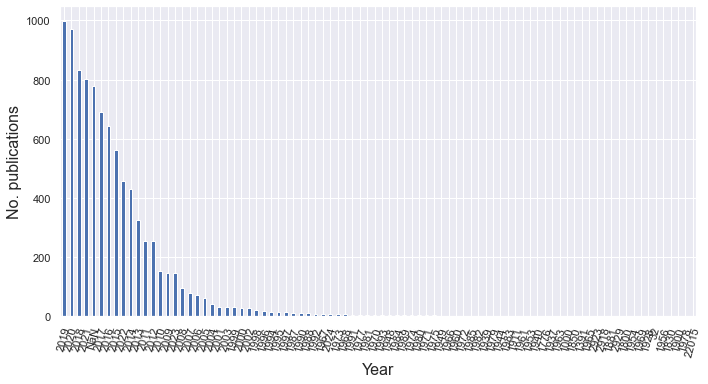

In [21]:
meta_df['Year'] = meta_df['Year'].fillna('NaN').astype(str).str.replace(".0","",regex=False)

prepare_fig(1.9, 1.9)
pd.value_counts(meta_df['Year']).plot.bar()

plt.ylabel("No. publications",fontsize=16)
plt.xlabel("Year",fontsize=16)
plt.xticks(rotation = 75); 

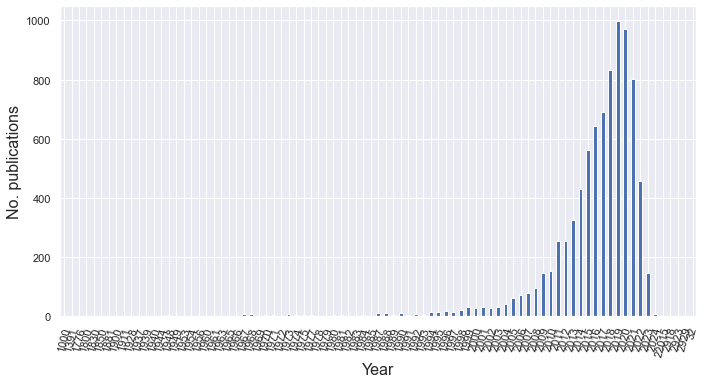

In [22]:
ry=pd.value_counts(meta_df['Year'])
ryns=ry.sort_index(key=lambda x: x.str.lower())
# ryns=ry.sort_index(ascending=False)

prepare_fig(1.9, 1.9)
ryns[0:-1].plot.bar()
plt.ylabel("No. publications",fontsize=16)
plt.xlabel("Year",fontsize=16)
plt.xticks(rotation = 75); 

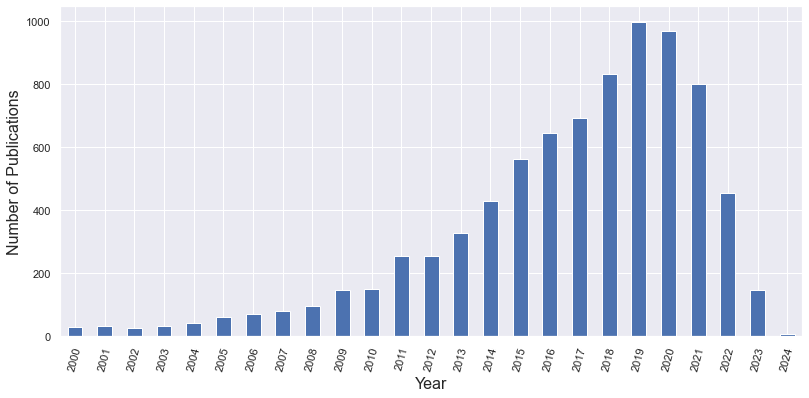

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming meta_df is your DataFrame containing publication data
# and 'Year' is the column representing the publication years

# Convert the 'Year' column to integers
meta_df['Year'] = pd.to_numeric(meta_df['Year'], errors='coerce')

# Filter the DataFrame for the 2000s
meta_df_2000s = meta_df[meta_df['Year'].between(2000, 2025)]

# Count the occurrences of each year
ry = pd.value_counts(meta_df_2000s['Year'])
ry.index = ry.index.astype(int)
ry = ry.astype(int)

# Sort the values based on the year
ryns = ry.sort_index()

# Plotting
prepare_fig(1.9, 1.9)
ryns.plot.bar()
plt.ylabel("Number of Publications", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.xticks(rotation=75)

plt.tight_layout() 
# Save the plot to a file
plt.savefig(Output_folder+'/Fig_publication_years_2000s.png', dpi=300)

plt.show()


Text(0.5, 0, 'Year')

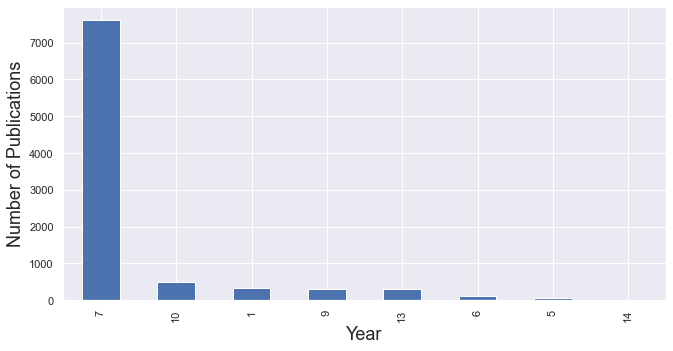

In [71]:
prepare_fig(1.8, 1.8)
pd.value_counts(meta_df['BibliographyType']).plot.bar()

plt.ylabel("Number of Publications", fontsize=18)
plt.xlabel("Year",fontsize=18)

## Note:
For the above plot, to changing the numbers of item types, we will upload another data from SSS_Refs_July29_2022.csv, which has the names of item types rather than numbers.

This csv file was converted from the Bibtex of SSS Mendeley files by using this online website https://www.bibtex.com/c/bibtex-to-csv-converter/


In [35]:
### meta_df2 = pd.read_csv('./Mend_Stats/SSS_Mend_excel/SSS_Refs_July29_2022.csv')

meta_df2 = pd.read_csv('./Mend_Stats/Mend_Collection/All_Mend_HP_Nov2023.csv', error_bad_lines=False)
# meta_df2 = pd.read_csv('./Mend_Stats/Mend_Collection/All_Mend_HP.csv', error_bad_lines=False)


meta_df2.columns

Index(['Item type', 'Authors', 'Editors', 'Title', 'Journal',
       'Publication year', 'Volume', 'Issue', 'Pages', 'Institution',
       'Edition', 'Publisher', 'Address', 'Book title', 'Proceedings title',
       'Date published', 'Date accessed', 'ISBN', 'ISBN (alt.)', 'ISSN',
       'ISSN (alt.)', 'URLs', 'DOI', 'PMID', 'Arxiv ID', 'Abstract',
       'Keywords', 'Notes', 'Sub-type', 'Series', 'Archive prefix',
       'Eprint ID', 'Primary class', 'Chapter', 'Pages cited', 'School',
       'How published', 'Date'],
      dtype='object')

In [36]:
meta_df2['Sub-type'].unique()
meta_df2['Item type'].unique()

array(['Journal Article', 'Report', 'Miscellaneous', 'Book',
       'Conference Paper', 'Ph.D. Thesis', 'Book Chapter', 'Unpublished'],
      dtype=object)

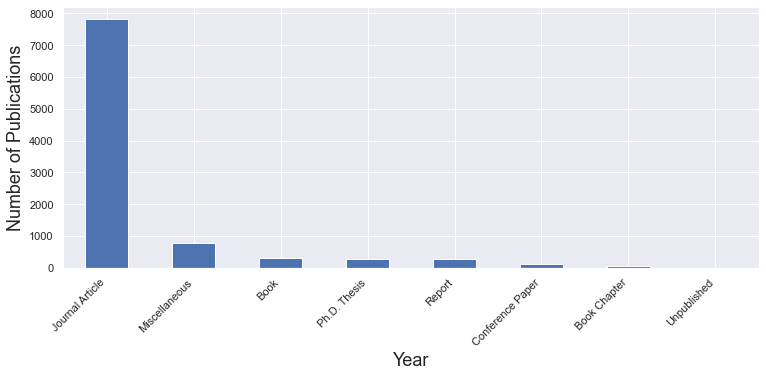

In [37]:
prepare_fig(1.8, 1.8)
pd.value_counts(meta_df2['Item type']).plot.bar()

plt.ylabel("Number of Publications", fontsize=18)
plt.xlabel("Year", fontsize=18)

plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels by 45 degrees and align to the right

plt.tight_layout()

# Save the plot to a file
plt.savefig(Output_folder+'/Fig_publication_types.png', dpi=300)

plt.show()


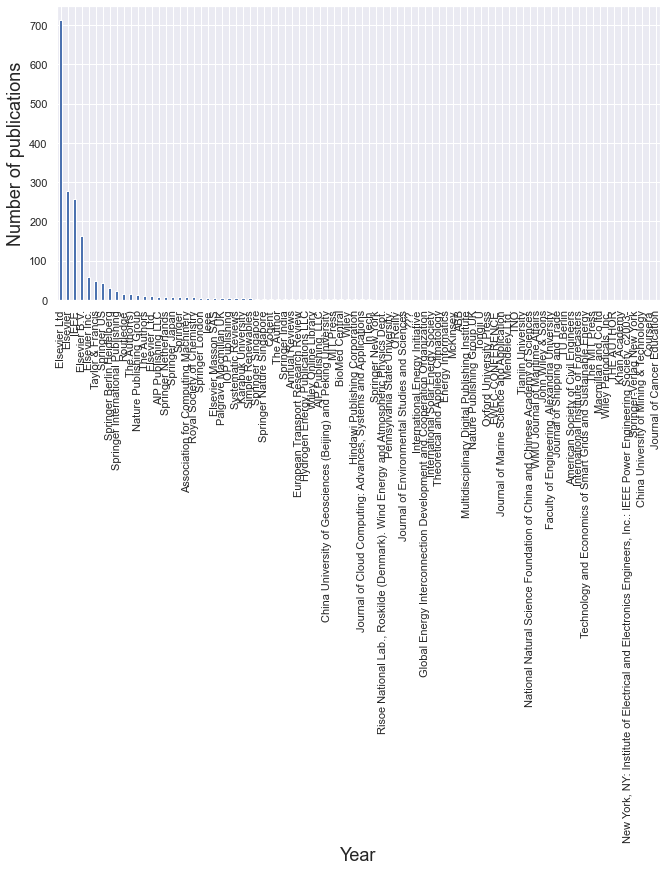

In [114]:
prepare_fig(1.8, 1.8)
pd.value_counts(meta_df['Publisher']).plot.bar()

plt.ylabel("Number of publications",fontsize=18)
plt.xlabel("Year",fontsize=18)

# plt.tight_layout()
# Save the plot to a file
plt.savefig(Output_folder+'/Fig_publisher_publications.png', dpi=300)

plt.show()

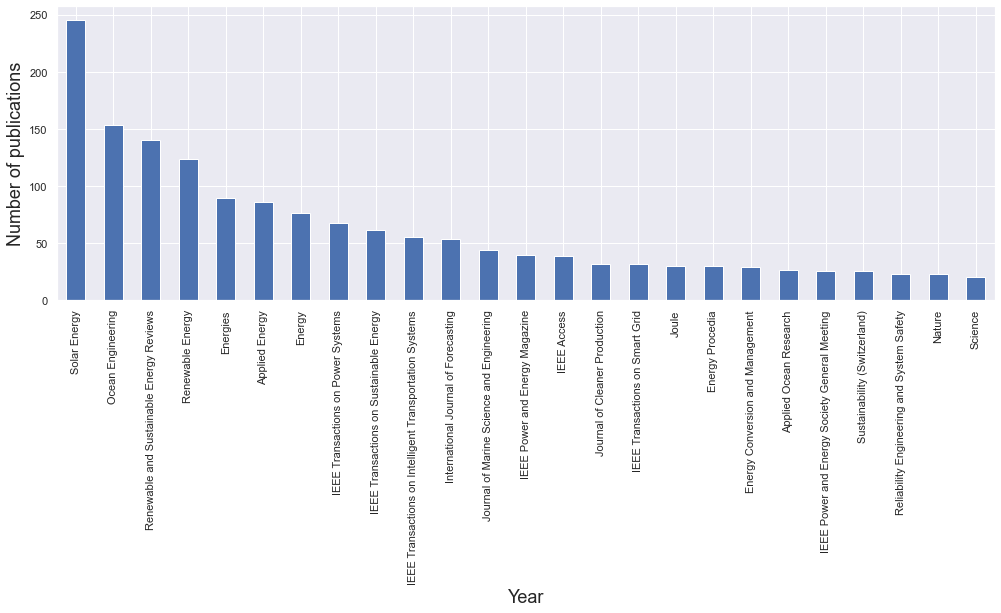

In [113]:
rj=pd.value_counts(meta_df['Journal'])

prepare_fig(2.8, 1.8)
# pd.value_counts(meta_df['Journal']).plot.bar()
rj[0:25].plot.bar()

plt.ylabel("Number of publications",fontsize=18)
plt.xlabel("Year",fontsize=18)

# plt.tight_layout()
# Save the plot to a file
plt.savefig(Output_folder+'/Fig_journal_publications.png', dpi=300)

plt.show()

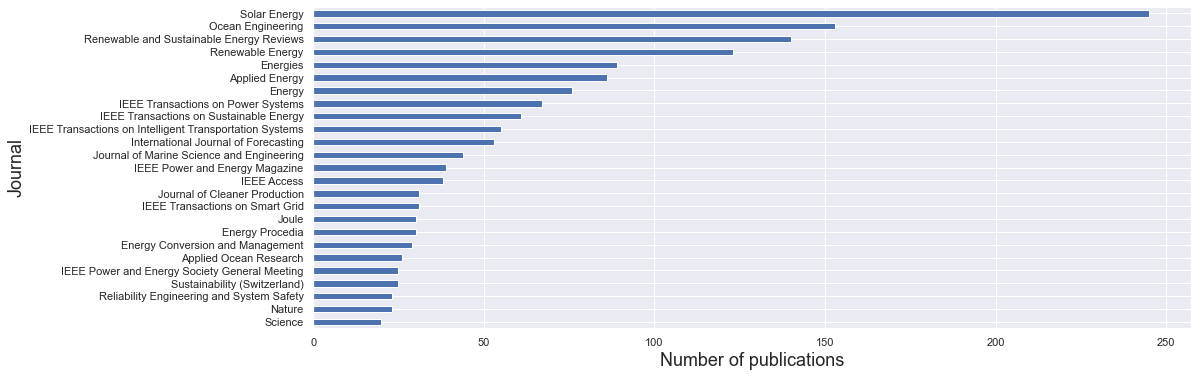

In [112]:
rj = pd.value_counts(meta_df['Journal'])

prepare_fig(2.8, 1.8)
rj[0:25].plot.barh()  # Use barh for horizontal bar plot

plt.xlabel("Number of publications", fontsize=18)  # Swap x-axis and y-axis labels
plt.ylabel("Journal", fontsize=18)  # Swap x-axis and y-axis labels

plt.gca().invert_yaxis()  # Reverse the y-axis

plt.tight_layout()
# Save the plot to a file
plt.savefig(Output_folder+'/Fig_y_journal_publications.png', dpi=300)

plt.show()

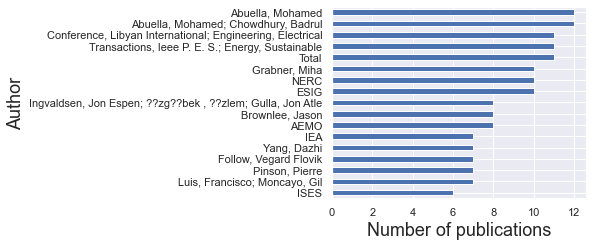

In [111]:
r_a = pd.value_counts(meta_df['Author'])

prepare_fig(1.4, 1.2)
r_a[0:17].plot.barh()  # Use barh for horizontal bar plot

plt.xlabel("Number of publications", fontsize=18)
plt.ylabel("Author", fontsize=18)

plt.gca().invert_yaxis()  # Reverse the y-axis

plt.tight_layout()

# Save the plot to a file
plt.savefig(Output_folder+'/Fig_publications_per_author.png', dpi=300)

plt.show()


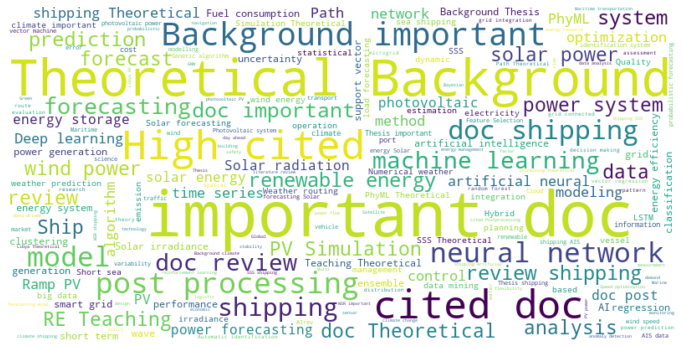

In [62]:
# Combine all keywords into a single string
keywords_text = ' '.join(meta_df['Custom3'].dropna())

# Word cloud for visualization of keywords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(keywords_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.tight_layout()
# Save the figure to a file
plt.savefig(Output_folder+'/Fig_Mend_User_Tags.png', dpi=300)
plt.show()



# Topic Modeling

## Preprocessing

In [29]:
# Load stopwords, bigrams, and stem rules
try:
    stopwords = set()
    with open('stopwords.txt', 'r') as f:
        stopwords = [w.strip() for w in f if w.strip()]
                
    print('loaded {} stopwords'.format(len(stopwords)))
except Exception as e:
    logging.error('failed to load stopwords.txt: {}'.format(e))

try:
    bigrams = dict()
    with open('bigrams.txt', 'r') as f:
        for line in f:
            if line.strip():
                a, b, c = line.split()
                bigrams[a, b] = c
        
    print('loaded {} bigrams'.format(len(bigrams)))
except Exception as e:
    logging.error('failed to load bigrams.txt: {}'.format(e))
    
try:
    stem_rules = dict()
    with open('stemming.txt', 'r') as f:
        for line in f:
            if line.strip():
                a, b = line.strip().split()
                stem_rules[a] = b
        
    print('loaded {} stem rules'.format(len(stem_rules)))
except Exception as e:
    logging.error('failed to load stemming.txt: {}'.format(e))

ERROR:root:failed to load stopwords.txt: [Errno 2] No such file or directory: 'stopwords.txt'
ERROR:root:failed to load bigrams.txt: [Errno 2] No such file or directory: 'bigrams.txt'
ERROR:root:failed to load stemming.txt: [Errno 2] No such file or directory: 'stemming.txt'


### Load saved data

In [30]:
saved_meta_df = pd.read_pickle(Output_folder+"/df_All_incld_bodytext_kywrd")

saved_meta_df.shape 

(9170, 33)

In [31]:
saved_meta_df.columns

Index(['BibliographyType', 'ISBN', 'Identifier', 'Author', 'Title', 'Journal',
       'Volume', 'Number', 'Month', 'Pages', 'Year', 'Address', 'Note', 'URL',
       'Booktitle', 'Chapter', 'Edition', 'Series', 'Editor', 'Publisher',
       'ReportType', 'Howpublished', 'Institution', 'Organizations', 'School',
       'Annote', 'Custom1', 'Custom2', 'Custom3', 'Custom4', 'Custom5',
       'body_text', 'keywords'],
      dtype='object')

In [32]:
meta_df['Abstract']=meta_df['Custom1']
meta_df['Abstract'].fillna('', inplace=True)

meta_df['kw']=meta_df['keywords']
meta_df['kw']=meta_df['kw'].astype("string");
type(meta_df.body_text[1])
type(meta_df.kw[1])

str

In [33]:
# meta_df.kw.describe()

In [34]:
texts = []; indx=[]
for p in range(len(meta_df)):
    try:
        text = (meta_df.Title[p] or '') + ' ' + (meta_df.Abstract[p] or '') + ' ' + (meta_df.kw[p] or '')
        text = text.lower()
        text = re.sub('[^a-zA-Z0-9]', ' ', text) # Replace punctation by spaces
        texts.append([w for w in text.split(' ') if w]) # Split on spaces, remove empty items
        indx.append(p)
   
    except:  ## To avoid KeyError
        continue 

In [35]:
print(len(meta_df), len(texts))

9170 8971


In [36]:
# Print common words
one_count = defaultdict(int)

for text in texts:
    for a in text:
        one_count[a] += 1
        
print('Top words')
display(pd.DataFrame(
    [(w, one_count[w], 'Yes' * (w in stopwords)) for w in top_k(one_count, 250)],
    columns=['word', 'count', 'in stopwords.txt?']))

Top words


,word,count,in stopwords.txt?
0,the,42257,
1,of,27979,
2,and,24105,
3,to,15658,
4,a,15025,
5,in,14344,
6,for,10578,
7,power,9899,
8,nan,8881,
9,data,8844,


In [37]:
# Print common bigrams
two_count = defaultdict(int)

for text in texts:
    for a, b in zip(text, text[1:]):
        if a not in stopwords and b not in stopwords:
            two_count[a, b] += 1
            
print('Top bigrams')
display(pd.DataFrame(
    [(w, two_count[w], 'Yes' * (w in bigrams)) for w in top_k(two_count, 250)],
    columns=['bigram', 'count', 'in bigrams.txt?']))

Top bigrams


,bigram,count,in bigrams.txt?
0,"(of, the)",6181,
1,"(in, the)",3222,
2,"(on, the)",1730,
3,"(based, on)",1658,
4,"(this, paper)",1523,
5,"(and, the)",1519,
6,"(to, the)",1457,
7,"(for, the)",1429,
8,"(wind, power)",1394,
9,"(in, this)",1274,


In [38]:
# Merge bigrams
for text in texts:
    i = 0
    
    while i < len(text) - 1:
        a, b = text[i], text[i + 1]
        
        if (a, b) in bigrams:
            text[i:i+2] = [bigrams[a,b]]
        else:
            i += 1

In [39]:
# Filter tokens
def filter_texts(texts, f):
    return [[token for token in text if f(token)] for text in texts] 

texts = filter_texts(texts, lambda t: t not in stopwords) # Filter stopwords
texts = filter_texts(texts, lambda t: len(t) > 1) # Remove single char words 
texts = filter_texts(texts, lambda t: not re.match('^[0-9]+$', t)) # Remove numbers

In [40]:
# Stemming
stemmer = gensim.parsing.PorterStemmer()
word_count = defaultdict(int)
stemming = dict()
unstemming = dict()


# Stem each word and count "word, stem" pairs
for text in texts:
    for token in text:
        word_count[token] += 1
    
# Sorted stems by frequency, the value for unstemming[stem] is overwritten 
# and should be the one with the highest count.
for token in sorted(word_count.keys(), key=word_count.get):
    stem = stemmer.stem(token)
    stemming[token] = stem
    unstemming[stem] = token

# Overwrite with user defined rules
for a, b in stem_rules.items():
    stemming[a] = b
    unstemming[b] = b

# Stem words
stemmed_texts = [[unstemming[stemming[token]] for token in text] for text in texts]

logging.info('stemming reduced {} to {} tokens'.format(len(stemming), len(unstemming)))
pd.DataFrame(
    [(
        token, 
        stemming[token], 
        unstemming[stemming[token]], 
        word_count[token]
    ) for token in top_k(word_count, k=250)],
    columns=['Original', 'Stem', 'Unstem', 'Count'])

INFO:root:stemming reduced 42896 to 32739 tokens


,Original,Stem,Unstem,Count
0,the,the,the,42257
1,of,of,of,27979
2,and,and,and,24105
3,to,to,to,15658
4,in,in,in,14344
5,for,for,for,10578
6,power,power,power,9899
7,nan,nan,nan,8881
8,data,data,data,8844
9,is,is,is,8222


## Create dictionary

In [41]:
# Remove papers with less than 25 words after preprocessing
# n = len(meta_df)
n = len(texts)
indices = [i for i in range(len(texts)) if len(stemmed_texts[i]) > 25]
# papers = [papers[i] for i in indices]
papers = [meta_df.Title[i] for i in indx]
final_texts = [stemmed_texts[i] for i in indices]

print('papers: {} (removed {})'.format(len(papers), n - len(texts)))

papers: 8971 (removed 0)


In [42]:
dic = gensim.corpora.Dictionary(final_texts)
dic.filter_extremes(0, 0.5) # Remove 
dic.filter_extremes(5, 1)   # 
corpus = [dic.doc2bow(text) for text in final_texts]

print('papers: {}'.format(len(corpus)))
print('dictionary size: {}'.format(len(dic)))

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary<0 unique tokens: []>
INFO:gensim.corpora.dictionary:built Dictionary<31752 unique tokens: ['1p', '20grid', '20nrcanada', '20technology', '21st']...> from 3525 documents (total 1201605 corpus positions)
INFO:gensim.utils:Dictionary lifecycle event {'msg': "built Dictionary<31752 unique tokens: ['1p', '20grid', '20nrcanada', '20technology', '21st']...> from 3525 documents (total 1201605 corpus positions)", 'datetime': '2023-11-24T04:43:05.152290', 'gensim': '4.2.0', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.17134-SP0', 'event': 'created'}
INFO:gensim.corpora.dictionary:discarding 18 tokens: [('of', 3411), ('are', 2233), ('as', 1916), ('for', 2975), ('on', 2694), ('the', 3412), ('an', 1766), ('that', 2258), ('to', 3259), ('is', 2817)]...
INFO:gensim.corpora.dictionary:keeping 31734 tokens which were in no less than 0 and no more than 1762 (=50.0%) documents
IN

papers: 3525
dictionary size: 5514


## Topic modeling

In [43]:
# Create frequency matrix
n, m = len(corpus), len(dic)
matrix = np.zeros((n, m))

for i, row in enumerate(corpus):
    for j, freq in row:
        matrix[i,j] = freq

In [44]:
# Run TFIDF model
tfidf_model = sklearn.feature_extraction.text.TfidfTransformer()
tfidf_matrix = tfidf_model.fit_transform(matrix).toarray()

In [45]:
nmf_model = sklearn.decomposition.NMF(
    n_components=num_topics,
    random_state=seed,
    tol=1e-9,
    max_iter=500,
    verbose=True)

# Train model
doc2topic = nmf_model.fit_transform(tfidf_matrix)
topic2token = nmf_model.components_

topic_norm = np.sum(topic2token, axis=1)
topic2token /= topic_norm[:,np.newaxis]
doc2topic *= topic_norm[np.newaxis,:]

doc_norm = np.sum(doc2topic, axis=1)
doc2topic /= doc_norm[:,np.newaxis]

violation: 1.0
violation: 0.22919333021513033
violation: 0.1538311010227491
violation: 0.13294312807080622
violation: 0.1356145397508238
violation: 0.12425120297757425
violation: 0.0900966351938871
violation: 0.06210025832197774
violation: 0.045129410120818184
violation: 0.03498312768456939
violation: 0.028589346201725697
violation: 0.024434591223366588
violation: 0.021682306836744398
violation: 0.019537461564018286
violation: 0.017605866736932343
violation: 0.015813173267588715
violation: 0.0141315950502723
violation: 0.012545124379595056
violation: 0.011046903458703506
violation: 0.00968516844415103
violation: 0.008355536786374271
violation: 0.007229347500972448
violation: 0.00629141153424841
violation: 0.005529803279758158
violation: 0.0049153723470463425
violation: 0.004402771178436396
violation: 0.003978702735020299
violation: 0.0036191694950644905
violation: 0.0033077582710109212
violation: 0.0030391220625728466
violation: 0.002803311200288707
violation: 0.002596262630415282
viol

violation: 1.085630967123322e-06
violation: 1.036654205545208e-06
violation: 9.899024371098196e-07
violation: 9.452698574486864e-07
violation: 9.026594327932368e-07
violation: 8.619760864972035e-07
violation: 8.231342819872257e-07
violation: 7.860500912593695e-07
violation: 7.506438478460358e-07
violation: 7.168383353774753e-07
violation: 6.845608859283211e-07
violation: 6.537414752714444e-07
violation: 6.243142520027796e-07
violation: 5.962157533037196e-07
violation: 5.693856360054733e-07
violation: 5.437662315479201e-07
violation: 5.19302728296781e-07
violation: 4.95942626546153e-07
violation: 4.736361124291421e-07
violation: 4.523351421112728e-07
violation: 4.3199424215784107e-07
violation: 4.12570039991466e-07
violation: 3.9402133059921004e-07
violation: 3.763081900846549e-07
violation: 3.59392994354478e-07
violation: 3.4323946591114367e-07
violation: 3.2781325146886763e-07
violation: 3.130815850761891e-07
violation: 2.990130645952083e-07
violation: 2.855776601096329e-07
violation:

In [46]:
rows = []

for label, vec in zip(labels, topic2token):
    rows.append([label] + ['{} ({:.2})'.format(dic[i], vec[i]) for i in np.argsort(vec)[::-1][:10]])

# Each row is a topic, columns are words ordered by weight 
pd.DataFrame(rows)

,0,1,2,3,4,5,6,7,8,9,10
0,A,solar (0.046),irradiance (0.029),radiation (0.015),cloud (0.013),sky (0.013),prediction (0.0087),satellite (0.0086),clear (0.0081),variables (0.0081),global (0.0078)
1,B,ship (0.06),fuel (0.022),emissions (0.017),consumption (0.016),speed (0.015),operation (0.01),sea (0.0098),wave (0.008),efficiency (0.008),performance (0.0069)
2,C,energy (0.042),renewable (0.018),electricity (0.016),system (0.014),storage (0.012),cost (0.0092),power (0.0087),grid (0.0086),demand (0.0084),generation (0.0071)
3,D,wind (0.11),power (0.042),ramp (0.021),speed (0.019),farms (0.014),prediction (0.01),generation (0.0089),turbine (0.0089),operation (0.0078),events (0.0074)
4,E,research (0.01),review (0.0077),we (0.0053),literature (0.0049),transport (0.0049),it (0.0047),development (0.0042),technology (0.0041),has (0.004),have (0.0038)
5,F,pv (0.075),power (0.037),photovoltaic (0.022),system (0.02),plants (0.018),output (0.015),generation (0.011),grid (0.0091),variables (0.0089),module (0.0077)
6,G,trajectory (0.042),ais (0.029),vessel (0.028),clustering (0.026),data (0.023),traffic (0.022),maritime (0.021),detection (0.011),automatic (0.01),identification (0.0089)
7,H,forecasting (0.099),ensemble (0.017),probabilistic (0.013),method (0.012),weather (0.012),load (0.0091),ahead (0.009),power (0.008),error (0.008),combined (0.0079)
8,I,route (0.06),optimization (0.029),algorithm (0.021),weather (0.014),method (0.01),problem (0.0099),objective (0.0094),planning (0.0093),voyage (0.0086),ship (0.0085)
9,J,learning (0.024),machine (0.017),data (0.016),prediction (0.013),method (0.01),we (0.0091),algorithm (0.0082),features (0.0073),ml (0.0071),performance (0.0071)


Topic 0 (A)
Topic 1 (B)
Topic 2 (C)
Topic 3 (D)
Topic 4 (E)
Topic 5 (F)
Topic 6 (G)
Topic 7 (H)
Topic 8 (I)
Topic 9 (J)
Topic 10 (K)
Topic 11 (L)


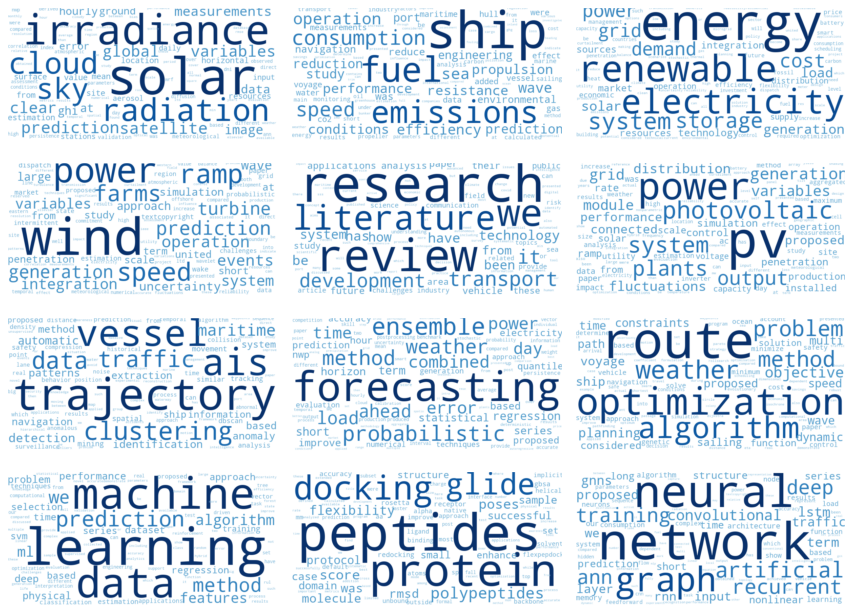

In [85]:
prepare_fig(2, 3)
for index in range(num_topics):
    mapping = dict()
    for i in np.argsort(topic2token[index])[::-1][:100]:
        if topic2token[index,i] > 0:
            mapping[dic[i]] = topic2token[index,i]
    
    def get_color(word, **kwargs):
        weight = kwargs['font_size'] / 60.0 * 0.6 + 0.4
        r, g, b = plt.get_cmap('Blues')(weight)[:3]
        return 'rgb(%s, %s, %s)' % (int(r * 255), int(g * 255), int(b * 255))
    
    wc = WordCloud(
        prefer_horizontal=True,
        max_font_size=75,
        #width=395,
        #height=250,
        scale=2,
        background_color='white', 
        color_func=get_color, 
        relative_scaling=0.5)
    wc.fit_words(mapping)
    
    print('Topic {} ({})'.format(index, labels[index]))
    plt.subplot(4, 3, index + 1)
    plt.imshow(wc.to_array(), interpolation='bilinear')
    plt.xticks([])
    plt.yticks([])
    
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0.1)

plt.tight_layout()
# Save the figure to a file
plt.savefig(Output_folder+'/Fig_topics.png', dpi=300)
plt.show()


## Visualization

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 3525 samples in 0.000s...
[t-SNE] Computed neighbors for 3525 samples in 0.271s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3525
[t-SNE] Computed conditional probabilities for sample 2000 / 3525
[t-SNE] Computed conditional probabilities for sample 3000 / 3525
[t-SNE] Computed conditional probabilities for sample 3525 / 3525
[t-SNE] Mean sigma: 0.023014
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.447311
[t-SNE] KL divergence after 1000 iterations: 1.161031


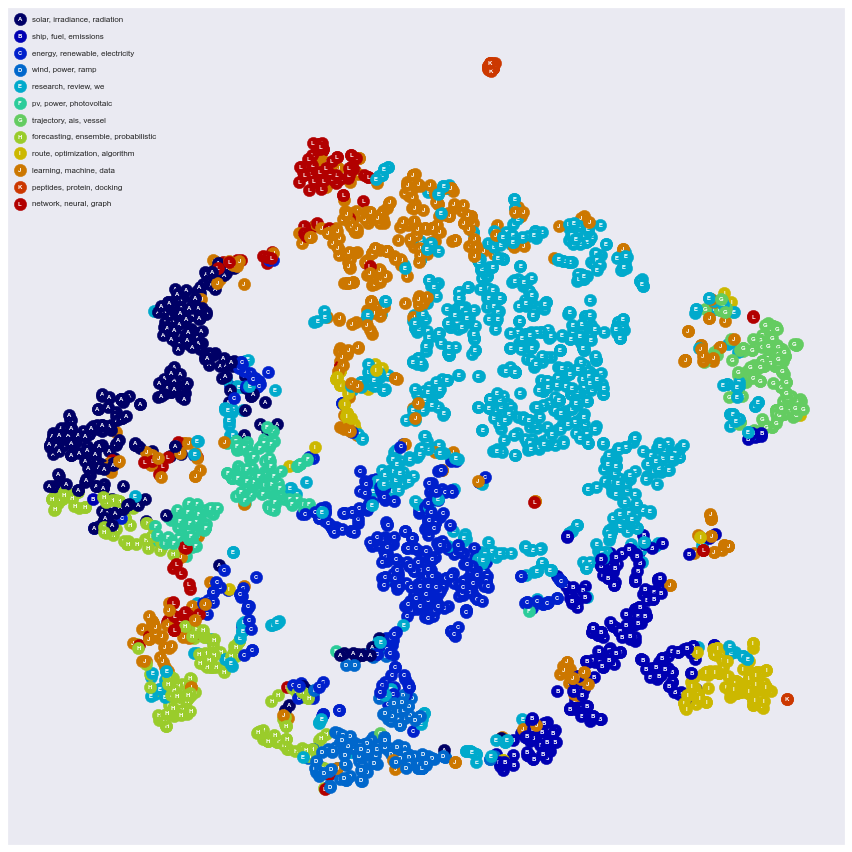

In [86]:
import sklearn.manifold
import sklearn.metrics.pairwise
from sklearn.decomposition import TruncatedSVD

def draw_dot(p, t, zorder=0):
    color = plt.get_cmap('jet')(float(t) / num_topics)
    color = 0.8 * np.array(color)[:3]
    
    plt.scatter(
        p[0], 
        p[1],
        s=150,
        c=[color],
        marker='o',
        linewidth=0.5,
        zorder=zorder)
    
    plt.text(
        p[0], 
        p[1],
        labels[t],
        fontsize=6,
        color='1',
        va='center',
        ha='center',
        fontweight='bold',
        zorder=zorder + 1)

# Lower dimensionality of original frequency matrix to improve cosine distances for visualization
reduced_matrix = TruncatedSVD(
    n_components=10, 
    random_state=seed
).fit_transform(tfidf_matrix)

# Learn model
model = sklearn.manifold.TSNE(
    verbose=True,
    metric='cosine',
    random_state=vis_seed,
    perplexity=20)
pos = model.fit_transform(reduced_matrix)

# Rotate visualization
theta = np.deg2rad(vis_angle + 60)
R = np.array([[np.cos(theta), np.sin(theta)], 
              [-np.sin(theta), np.cos(theta)]])
pos = np.dot(pos, R)

# Resize so xy-position is between 0.05 and 0.95
pos -= (np.amin(pos, axis=0) + np.amax(pos, axis=0)) / 2
pos /= np.amax(np.abs(pos))
pos = (pos * 0.5) + 0.5
pos = (pos * 0.9) + 0.05

prepare_fig(2, 4)
plt.xticks([])
plt.yticks([])
plt.xlim(0, 1)
plt.ylim(0, 1)
zorder = 0

# Draw dots
for i in np.random.permutation(len(doc2topic)):
    topic_id = np.argmax(doc2topic[i])
    draw_dot(pos[i], topic_id, zorder)
    zorder += 2

# Draw legend
for i in range(num_topics):    
    y = 0.985 - i * 0.02
    label = ', '.join(dic[w] for w in np.argsort(topic2token[i])[::-1][:3])

    draw_dot([0.015, y], i)
    plt.text(0.03, y, label, ha='left', va='center', fontsize=8, zorder=zorder)
    zorder += 1

plt.tight_layout()
# Save the figure to a file
plt.savefig(Output_folder+'/Fig_map_topics.png', dpi=300)
plt.show()

In [49]:
def on_select(i):
    print(meta_df.Title[i])
    
    prepare_fig(1, 2)
    plt.xticks([])
    plt.yticks([])
    
    if 0 <= i < pos.shape[0]:
        
        plt.scatter(pos.T[0], pos.T[1], c='.5')
        plt.scatter(pos[i,0], pos[i,1], c='red',s=100, marker='x')
        plt.show()

        top_words = np.argsort(topic2token, axis=1)[:,::-1]
        ticks = ['{} ({})'.format(l, ', '.join(dic[v] for v in w[:3])) for l, w in zip(labels, top_words)]

        fig = prepare_fig(1, 2)
        plt.barh(range(num_topics), doc2topic[i])
        plt.xlim(0, 1)
        plt.ylim(num_topics, -1)
        plt.yticks(range(num_topics), ticks)
        plt.show()

        print(meta_df.Abstract[i])

# options = sorted([((meta_df.Title[i] or '').strip()[:50], i) for i, p in enumerate(papers)])
options = sorted([((meta_df.Title[i] or '').strip()[:50], i) for i in indx])
widget = widgets.interactive(on_select, i=options)
widget.children[-1].layout.height = '2000px'
widget

interactive(children=(Dropdown(description='i', options=(('$ FWLYH 3RZHU 0DQDJHPHQW 6FKHPH % DVHG RQ 5DPS 5DW'…

In [87]:
print("Length of meta_df:", len(meta_df))
print("Length of doc2topic:", len(doc2topic))

Length of meta_df: 9170
Length of doc2topic: 3525


### Sort data with topics 
The documents are matched with top of 12 topics.

In [99]:
dic_topic={'title': [], 'abstract': [], 'topics_3max': [], 'topics_max': [],  'topics_score': [],  'topics_id': []}

top_words = np.argsort(topic2token, axis=1)[:,::-1]
ticks = ['{} ({})'.format(l, ', '.join(dic[v] for v in w[:7])) for l, w in zip(labels, top_words)]

# for i in indx[0:len(doc2topic)-1]:
#     dic_topic['title'].append(meta_df.Title[i])
#     dic_topic['abstract'].append(meta_df.Abstract[i])
#     dic_topic['topics_score'].append(list(doc2topic[i]))
#     dic_topic['topics_id'].append(ticks)
#     tops3=doc2topic[i].argsort()[::-1][0:3].tolist()
#     dic_topic['topics_3max'].append([ticks[tp] for tp in tops3])
#     topic_title= np.argmax(doc2topic[i])
#     dic_topic['topics_max'].append(ticks[topic_title]) 
    
    
# topics_df= pd.DataFrame(dic_topic)
# topics_df.head()

for i in range(len(doc2topic)):
    try:
        dic_topic['title'].append(meta_df.Title[i])
        dic_topic['abstract'].append(meta_df.Abstract[i])
        dic_topic['topics_score'].append(list(doc2topic[i]))
        dic_topic['topics_id'].append(ticks)
        tops3=doc2topic[i].argsort()[::-1][0:3].tolist()
        dic_topic['topics_3max'].append([ticks[tp] for tp in tops3])
        topic_title= np.argmax(doc2topic[i])
        dic_topic['topics_max'].append(ticks[topic_title]) 
    except: continue
    
topics_df= pd.DataFrame(dic_topic)
topics_df.head()

,title,abstract,topics_3max,topics_max,topics_score,topics_id
0,The path of the smart grid,,"[Topic 2 (energy, renewable, electricity, syst...","Topic 2 (energy, renewable, electricity, syste...","[0.0, 0.0, 0.449579754312077, 0.01501546964171...","[Topic 0 (solar, irradiance, radiation, cloud,..."
1,Regression and Generalized Additive Model to E...,,"[Topic 9 (learning, machine, data, prediction,...","Topic 9 (learning, machine, data, prediction, ...","[0.1239373081018689, 0.0021504386998764057, 0....","[Topic 0 (solar, irradiance, radiation, cloud,..."
2,A Multi-model Combination Approach for Probabi...,Short-term probabilistic wind power forecastin...,"[Topic 7 (forecasting, ensemble, probabilistic...","Topic 7 (forecasting, ensemble, probabilistic,...","[0.0, 0.0, 0.13723117733912701, 0.300800738546...","[Topic 0 (solar, irradiance, radiation, cloud,..."
3,The Malaysia-Japan Model on Technology Partner...,,"[Topic 2 (energy, renewable, electricity, syst...","Topic 2 (energy, renewable, electricity, syste...","[0.013558911105261586, 0.0, 0.5920782319984649...","[Topic 0 (solar, irradiance, radiation, cloud,..."
4,An artificial neural network to assess the imp...,,"[Topic 11 (network, neural, graph, artificial,...","Topic 11 (network, neural, graph, artificial, ...","[0.20334659744097316, 0.0, 0.11536774187076915...","[Topic 0 (solar, irradiance, radiation, cloud,..."


In [100]:
df_name=str(Output_folder.split('_')[0])
topics_df.to_excel(Output_folder+'/df_'+df_name+'_Mend_Topics.xlsx')


In [101]:
topics_df.shape

(3451, 6)

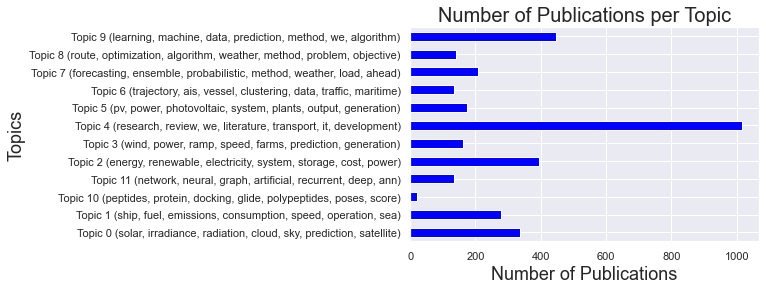

In [110]:
# Assuming topics_df is your DataFrame
# For example, create a sample DataFrame for illustration

# Count the occurrences of each topic
publications_per_topic = topics_df['topics_max'].value_counts().sort_index()

# Bar plot with swapped axes
prepare_fig(1.8, 1.4)
publications_per_topic.plot.barh(color='blue')  # Use barh for horizontal bar plot
plt.ylabel('Topics', fontsize=18)  # Swap x-axis and y-axis labels
plt.xlabel('Number of Publications', fontsize=18)  # Swap x-axis and y-axis labels
plt.title('Number of Publications per Topic', fontsize=20)

plt.tight_layout()

# Save the plot to a file
plt.savefig(Output_folder+'/Fig_publications_per_topics.png', dpi=300)

plt.show()


In [129]:
print(publications_per_topic.sum())
publications_per_topic

3451


Topic 0 (solar, irradiance, radiation, cloud, sky, prediction, satellite)         336
Topic 1 (ship, fuel, emissions, consumption, speed, operation, sea)               279
Topic 10 (peptides, protein, docking, glide, polypeptides, poses, score)           21
Topic 11 (network, neural, graph, artificial, recurrent, deep, ann)               134
Topic 2 (energy, renewable, electricity, system, storage, cost, power)            394
Topic 3 (wind, power, ramp, speed, farms, prediction, generation)                 162
Topic 4 (research, review, we, literature, transport, it, development)           1017
Topic 5 (pv, power, photovoltaic, system, plants, output, generation)             174
Topic 6 (trajectory, ais, vessel, clustering, data, traffic, maritime)            135
Topic 7 (forecasting, ensemble, probabilistic, method, weather, load, ahead)      209
Topic 8 (route, optimization, algorithm, weather, method, problem, objective)     142
Topic 9 (learning, machine, data, prediction, method, 

In [67]:
saved_meta_df.columns

Index(['BibliographyType', 'ISBN', 'Identifier', 'Author', 'Title', 'Journal',
       'Volume', 'Number', 'Month', 'Pages', 'Year', 'Address', 'Note', 'URL',
       'Booktitle', 'Chapter', 'Edition', 'Series', 'Editor', 'Publisher',
       'ReportType', 'Howpublished', 'Institution', 'Organizations', 'School',
       'Annote', 'Custom1', 'Custom2', 'Custom3', 'Custom4', 'Custom5',
       'body_text', 'keywords'],
      dtype='object')